In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 1. MNIST

Trains a fully connected neural network to identify handwritten digits using MNIST dataset.

## 1. Setup

Imports and defines the objects needed for this example.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from deeptrack.features import LoadImage, Lambda, ConditionalSetProperty
from deeptrack.models import FullyConnected

PATH_TO_DATASET = os.path.abspath("./datasets/MNIST")

TRAINING_SET_PATH = os.path.join(PATH_TO_DATASET, "training_set.npy")
TRAINING_LABELS_PATH = os.path.join(PATH_TO_DATASET, "training_labels.npy")
VALIDATION_SET_PATH = os.path.join(PATH_TO_DATASET, "validation_set.npy")
VALIDATION_LABELS_PATH = os.path.join(PATH_TO_DATASET, "validation_labels.npy")


## 2. Defining the dataset

### 2.1 Defining the training data

The dataset is how we provide the network with training data. For this example we create the dataset by loading it from storage using `LoadImage` and reshaping the data to match the network input shape using `Lambda`.

Moreover, we want to distinguish the training set and the validation set. There are several ways to accomplish this, but here we use `ConditionalSetProperty`, which will set the path from which to load the training data to `VALIDATION_SET_PATH` if `validation` is `True`.

We combine the different object using the `+` operator, which tells deeptrack to call the left hand object and pass the output into the right hand object.

In [3]:
# Load the images from storage
load_images = LoadImage(path=TRAINING_SET_PATH)

# Conditionally set where to load the images from
conditional_load_images = ConditionalSetProperty(
    load_images,
    condition="validation",
    path=VALIDATION_SET_PATH
)

# Flatten the data to match network expectations
flatten = Lambda(lambda: lambda images: np.reshape(images, (images.shape[0], 28 * 28)))

# Combine into dataset
mnist_set = conditional_load_images + flatten

### 2.2 Defining the training labels

Labels are created similarly. We load the labels using `LoadImage`, and use `ConditionalSetProperty` to conditionally set where to load the labels from.

In [4]:
# Load labels from storage
load_labels = LoadImage(path=TRAINING_LABELS_PATH)

# Conditionally set where to load labels from
mnist_labels = ConditionalSetProperty(
    load_labels,
    condition="validation",
    path=VALIDATION_LABELS_PATH
)

### 2.3 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`. Since we flattened the images we need to reshape the images again to visualize them.

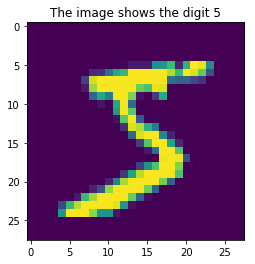

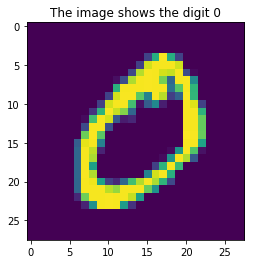

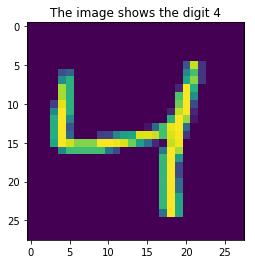

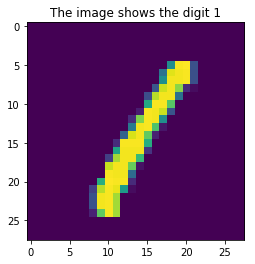

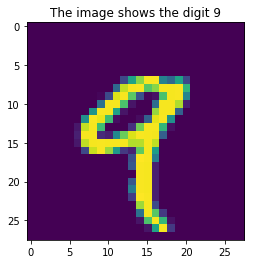

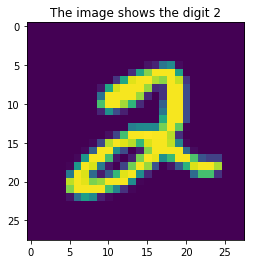

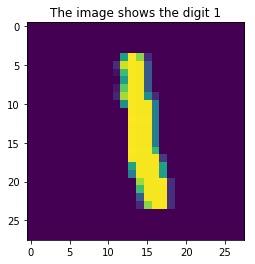

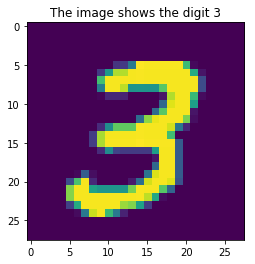

In [5]:
NUMBER_OF_IMAGES = 8 

array_of_images = mnist_set.resolve()
array_of_labels = mnist_labels.resolve()

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title("The image shows the digit {0}".format(array_of_labels[image_index]))
    plt.show()

## 3. Defining the network

The network used is a fully connected neural network. Here we define the network architecture, loss function and the optimizer.

In [6]:
model = FullyConnected(
    input_shape=(28 * 28,),
    dense_layers_dimensions=(128, 128, 64, 64, 32, 32),
    number_of_outputs=10,
    output_activation="softmax",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer="adam"
)

## 4. Training the network

The network is trained for 100 epochs using standard Keras syntax.

By passing the argument `validation=True` to `resolve` we toggle `ConditionalSetProperty` to load from the validation files instead.

In [7]:
h = model.fit(
    mnist_set.resolve(),           
    mnist_labels.resolve(),
    validation_data=(mnist_set.resolve(validation=True),
                     mnist_labels.resolve(validation=True)),
    epochs=50
)

Epoch 1/50
1875/1875 [==============================] - 5s 3ms/step - loss: 1.2834 - accuracy: 0.5718 - val_loss: 0.8419 - val_accuracy: 0.7291
Epoch 2/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7213 - accuracy: 0.7811 - val_loss: 0.5696 - val_accuracy: 0.8307
Epoch 3/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5502 - accuracy: 0.8327 - val_loss: 0.5024 - val_accuracy: 0.8484
Epoch 4/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4664 - accuracy: 0.8614 - val_loss: 0.4350 - val_accuracy: 0.8727
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4445 - accuracy: 0.8663 - val_loss: 0.4320 - val_accuracy: 0.8701
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4058 - accuracy: 0.8792 - val_loss: 0.4051 - val_accuracy: 0.8748
Epoch 7/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3767 - accuracy: 0.8866 - val_loss: 0.3637 - val_accuracy:

## 5. Evaluating the training

### 5.1 Loss vs validation
We plot the metrics evaluated on the training data compared to the validation data to spot potential overtraining. 

[]

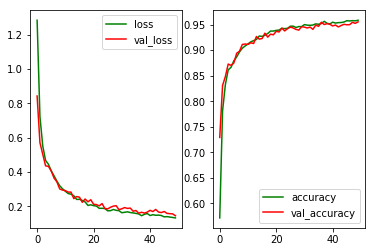

In [8]:
plt.subplot(1, 2, 1)
plt.plot(h.history["loss"], 'g')
plt.plot(h.history["val_loss"], 'r')
plt.legend(["loss", "val_loss"])

plt.subplot(1, 2, 2)
plt.plot(h.history["accuracy"], 'g')
plt.plot(h.history["val_accuracy"], 'r')
plt.legend(["accuracy", "val_accuracy"])

plt.plot()

### 5.2 Prediction vs actual

We show a few images, the true digit and the predicted digit

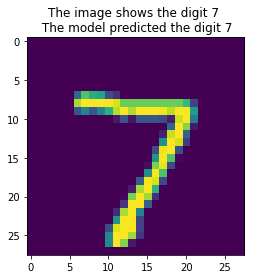

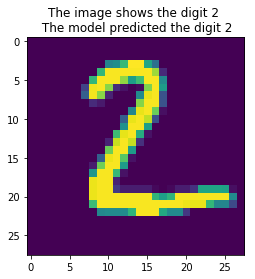

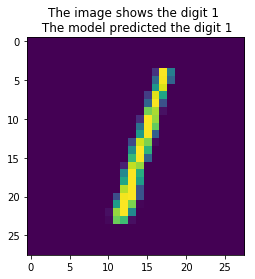

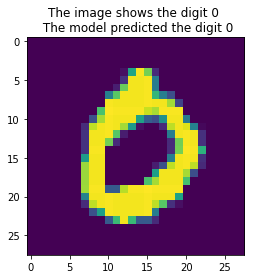

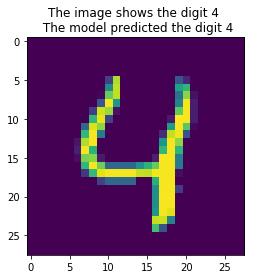

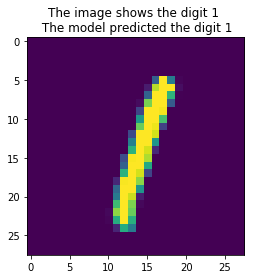

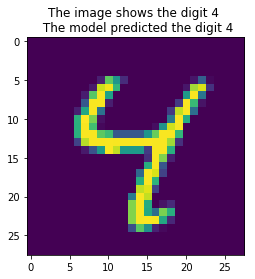

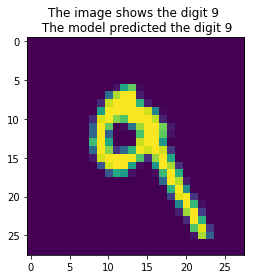

In [9]:
NUMBER_OF_IMAGES = 8 
TITLE_STRING = "The image shows the digit {0} \n The model predicted the digit {1}"

array_of_images = mnist_set.resolve(validation=True)
array_of_labels = mnist_labels.resolve(validation=True)

predicted_digits = np.argmax(model.predict(array_of_images), axis=1)

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_labels[image_index], predicted_digits[image_index]))
    plt.show()

### 5.3 Visualizing errors

We show a few images which the model predicted inaccurately

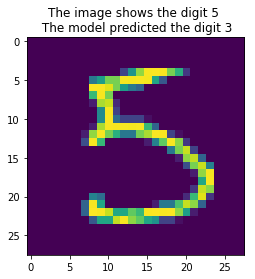

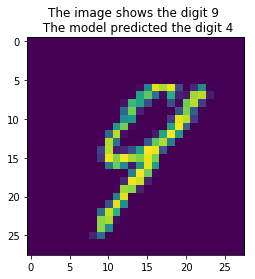

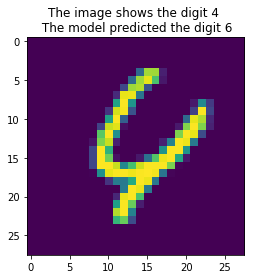

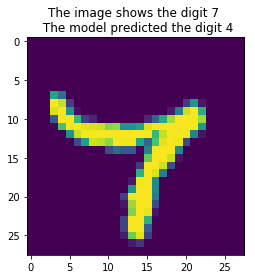

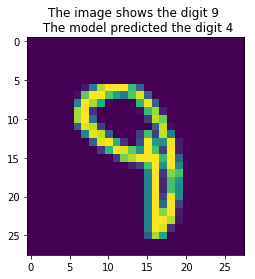

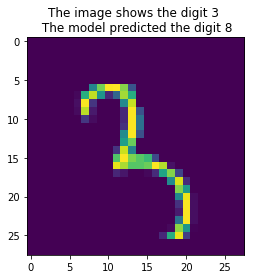

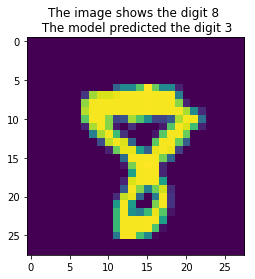

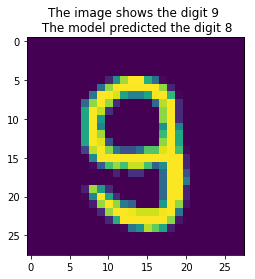

In [10]:
NUMBER_OF_IMAGES = 8 

model_is_wrong = predicted_digits != array_of_labels

array_of_hard_images = array_of_images[model_is_wrong]
array_of_hard_labels = array_of_labels[model_is_wrong]
inaccurately_predicted_digits = predicted_digits[model_is_wrong]

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_hard_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_hard_labels[image_index], inaccurately_predicted_digits[image_index]))
    plt.show()